In [2]:
import numpy as np
import os
from scipy import signal
import UDIP_Lib.UDIP_Lib_V19 as UDIP_Lib  #making updating UDIP_Lib easier
import Fitting.RockSat_1_14_fitting_functions as R_fitting
import json
import pandas as pd
import matplotlib.pyplot as plt
from RockSat_json.RockSat_json import *
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

# Fitting functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

#fitting and helper functions

def gen_fit(x_raw,y_raw):
    x,y = data_processing(x_raw,y_raw)
    g = [2, 2, 2, -14, 80, 5*(10**10), 700 ]    #intial guess
    b = [
        (-3,  -3, 2, -np.inf, -np.inf, 0     , 0    ),
        ( 3,   3, 5, np.inf,  np.inf, np.inf, 5000 )
        ] #bounds
    popt, pcov = optimize.curve_fit(model,x,y,g,bounds=b)
    max_1 = np.max(x)
    min_1 = np.min(x)
    t = np.linspace(min_1,max_1,num=1000)
    return t, model(t,*popt),popt,pcov #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0]

def model(V, Vf, V0, VP,  b, m1, ne, te):
    I = np.zeros(len(V))
    I[V <= Vf] = lin(V[V <= Vf], m1) - lin(Vf, m1) + b
    Vtrans = (V > Vf) & (V < VP)
    I[Vtrans] = exp(V[Vtrans], ne, te, VP) + b
    I[V >  VP] = sqrt(V[V >  VP], ne, te, V0) - sqrt(VP, ne, te, V0) + b
    return I

def lin(x, m):#linear--full model square root
    return m * x

def exp(x, ne, te, V1):
    q_e = 1.602e-19  # Electron charge [C]
    K_b = 1.381e-23  # Boltzmann constant [J/K]
    m_e = 9.109e-31  # Electron mass [kg]
    R = (3.0 / 16.0) * 2.54  # Radius of probe [cm]
    L = 3.25 * 2.54  # Length of probe [cm]
    A = 2.0 * np.pi * R * L + np.pi * (R ** 2)  # Surface area [cm^2]
    I0 = ne * q_e * np.sqrt(K_b * te/ (2.0 * np.pi * m_e)) * A * 1e-9  # [nA]
    k = q_e / (K_b * te)
    return I0 * np.exp(k * (x - V1))

def sqrt(x,n,t,V0):# square root
    q_e = 1.602 * 10**-19 #C                charge of an electron
    K_b = 1.381 * 10**-23 #m^2*kg/(s^2*K)   boltzman constant
    m_e = 9.109 * 10**-31 #kg               mass of an electron
    R = (3./16.) * 0.0254 #radius of probe
    L = (3.25) * 0.0254 #length of probe
    A = 2. * np.pi * R * L + np.pi * (R ** 2) #area of probe cylinder with out a bottom

    k = q_e / (K_b * t)
    I0 =n * q_e * np.sqrt(K_b * t / (2. * np.pi * m_e)) * A / (10**-9)
    return I0 * np.sqrt(1.0 + k*(x - V0))

def data_processing(x_raw,y_raw):#remove data points below -2 and above the peak to reduce datapoints going to the fitting routine
    x = np.nan_to_num(x_raw, nan=0.0)
    y = np.nan_to_num(y_raw, nan=0.0)
    x = x[6:]
    y = y[6:]
    return x,y

# gathering altitude and time data from rockon drive

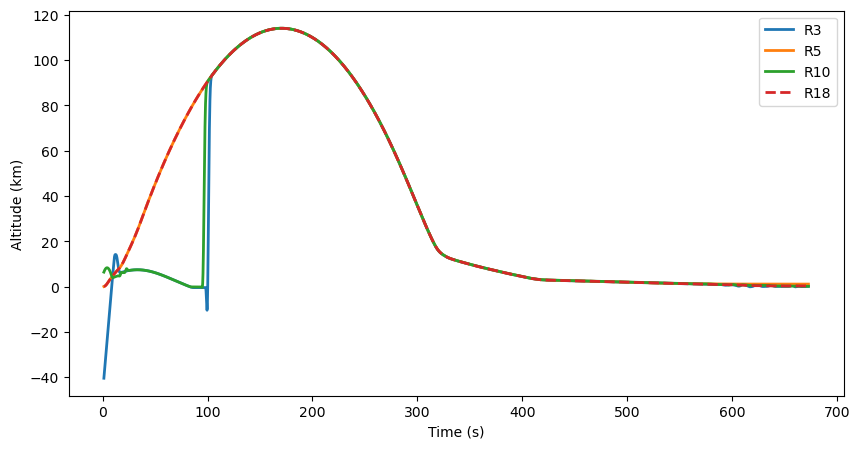

[0.101, 0.107, 0.115, 0.125, 0.138, 0.153, 0.171, 0.192, 0.216, 0.242]
[0.07, 0.086, 0.103, 0.122, 0.143, 0.166, 0.189, 0.215, 0.242, 0.271]


In [4]:
times3 = []
times5 = []
times10 = []
times18 = []
altitudes3 = []
altitudes5 = []
altitudes10 = []
altitudes18 = []

with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R5 POSDAT 06202024.txt", "r") as rockonData5: #R5
    next(rockonData5)  # Skip the header
    for line in rockonData5:
        parts = line.strip().split()
        times5.append(float(parts[1]))  # time values
        altitudes5.append(float(parts[9]) / 1000)  # altitude values in km
        
with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R3 POSDAT 06202024.txt", "r") as rockonData3: #R3
    next(rockonData3)  # Skip the header
    for line in rockonData3:
        parts = line.strip().split()
        times3.append(float(parts[1]))  # time values
        altitudes3.append(float(parts[9]) / 1000)  # altitude values in km

with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R10 POSDAT 06202024.txt", "r") as rockonData10: #R10
    next(rockonData10)  # Skip the header
    for line in rockonData10:
        parts = line.strip().split()
        times10.append(float(parts[1]))  # time values
        altitudes10.append(float(parts[9]) / 1000)  # altitude values in km

with open(r"C:\Users\ashto\DAPPEr2\UDIP4\data\NRW-6381 ROCKON 41.133 R18 POSDAT 06202024.txt", "r") as rockonData18:
    next(rockonData18)  # Skip the header
    for line in rockonData18:
        parts = line.strip().split()
        times18.append(float(parts[1]))  # time values
        altitudes18.append(float(parts[9]) / 1000)  # altitude values in km


apogee3 = max(altitudes3)
apogee5 = max(altitudes5)
apogee10 = max(altitudes10)
apogee18 = max(altitudes18)
#print(apogee3)
plt.figure(figsize=(10, 5))
plt.plot(times3, altitudes3, label= "R3", lw=2)
plt.plot(times5, altitudes5, label= "R5",lw=2)
plt.plot(times10, altitudes10, label= "R10",lw=2)
plt.plot(times18, altitudes18, label= "R18",lw=2, ls='--')

plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
#plt.xlim(650,700) #zoom on end
#plt.ylim(0,1)
plt.legend()
plt.show()
print(altitudes18[:10])
print(altitudes5[:10])

#print(len(altitudes5))

#looks like R3,R10 messed up until t=100s, then they all make the same shape, I am using R5 


In [5]:
print(times5[988])
altafter100 = altitudes5[388:]

100.0


In [6]:
packets = import_data('../UDIP4/data/packets/UDIP_4_800s.json')

In [7]:
#From Josh

ne = np.array([])
Te = np.array([])
Imax = np.array([])
t_lin = np.array([])
starting_sweep = 0
stopping_sweep = 900
st = packets['packets']['Full'][f'{starting_sweep}']['Start']
fin = packets['packets']['Full'][f'{stopping_sweep}']['Start']
# print((st/1000) - 57,(fin/1000) - 57)
# print(len(packets['packets']['Full']))
step   = 1
for sweep in range(starting_sweep, stopping_sweep, step):
    c = 6
    V = np.array(packets['packets']['Full'][f'{sweep}']['Voltage'][c:]) 
    I = -np.array(packets['packets']['Full'][f'{sweep}']['Current0'][c:]) * 1e9
    Vfit, Ifit, popt, pcov = gen_fit(V, I)
    start = packets['packets']['Full'][f'{sweep}']['Start']
    stop  = packets['packets']['Full'][f'{sweep}']['Stop']
    t_lin = np.append(t_lin, (start + stop)/2/1000 - 57)
    ne = np.append(ne,popt[5])
    Te = np.append(Te,popt[6])
    Imax = np.append(Imax, np.max(I))
    
#which sweep is when we launch??, fix starting_sweep and stopping_sweep



C:\Users\ashto\AppData\Local\Temp\ipykernel_2676\3544887088.py:52: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))


# Time vs temp from UDIP_4.json

Text(0, 0.5, 'Temp')

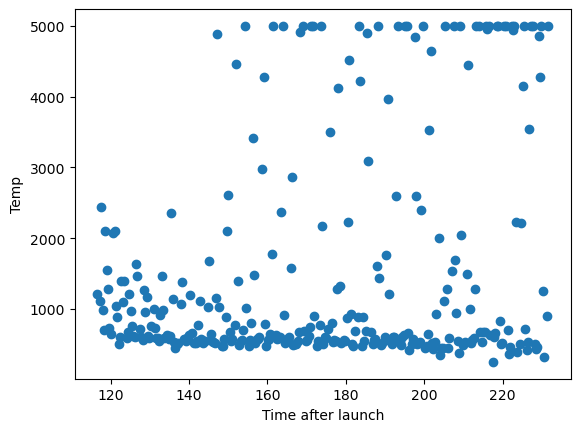

In [8]:
plt.scatter(t_lin[170:470], Te[170:470])
plt.xlabel("Time after launch")
plt.ylabel("Temp")
#plt.xlim(110,240)
#plt.ylim(0,4000)
#subtract 57 seconds to adjust for the 57 seconds of sensor data collection before launch, this was done already in Josh's code

In [9]:
#tV = np.array(packets['packets']['Full']['0']['Voltage'][4:])
#tI = np.array(packets['packets']['Full']['0']['Current0'][4:]) * -1e9
#plt.plot(tV,tI)
#a,b,c,d = R_fitting.gen_fit(tV,tI)
#aaa = np.linspace(-6,6,100)

#bbb = R_fitting.model(aaa, c[0],c[1],c[2],c[3],c[4],c[5])
#print(bbb)
#plt.plot(aaa,bbb)
#print(c[4])

#need to play with fitting algorithm to make it not stop at 0 and 10000 bounds, check data_processing and gen_fit, maybe bounds or guess

In [10]:
#print(Te)

In [11]:
#T  = 0
#print(Te[322])
#tV = np.array(packets['packets']['Full']['320']['Voltage'][10:])
#tI = np.array(packets['packets']['Full']['320']['Current0'][10:])
#tI = tI * -1e9
#plt.plot(tV,tI,".")
#a,b,popt,d = R_fitting.gen_fit(tV,tI)
#Voltages = np.linspace(-6,6,100)
#print(tV)
#print(len(tV))
#print(tI)
#print(len(tI))
#modelI = R_fitting.model(Voltages, popt[0],popt[1],popt[2],popt[3],popt[4],popt[5])
#plt.plot(Voltages,modelI,".")

In [12]:
#tV = np.array(packets['packets']['Full']['205']['Voltage'][4:])
#tI = np.array(packets['packets']['Full']['205']['Current0'][4:])
#tI = tI * -1e9
#plt.plot(tV,tI,".")
#a,b,popt,d = R_fitting.gen_fit(tV,tI)
#Voltages = np.linspace(-6,6,100)
#print(tV)
#print(len(tV))
#print(tI)
#print(len(tI))
#modelI = R_fitting.model(Voltages, popt[0],popt[1],popt[2],popt[3],popt[4],popt[5])
#plt.plot(Voltages,modelI,".")
#print(popt[4])


## matching data points

900


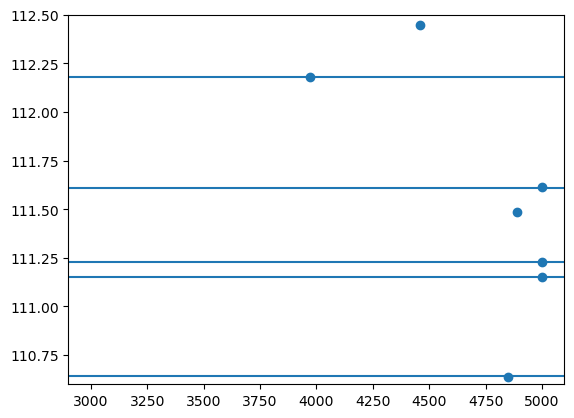

In [13]:
altitudes_func = interp1d(times5, altitudes5)
altitudes_interp = altitudes_func(t_lin)
print(len(altitudes_interp))
plt.scatter(Te[153:492],altitudes_interp[153:492])
plt.ylim(110.6,112.5)
plt.xlim(2900,5100)
plt.axhline(112.18)
plt.axhline(111.61)
plt.axhline(111.23)
plt.axhline(111.15)
plt.axhline(110.64)

# Temperature vs altitude

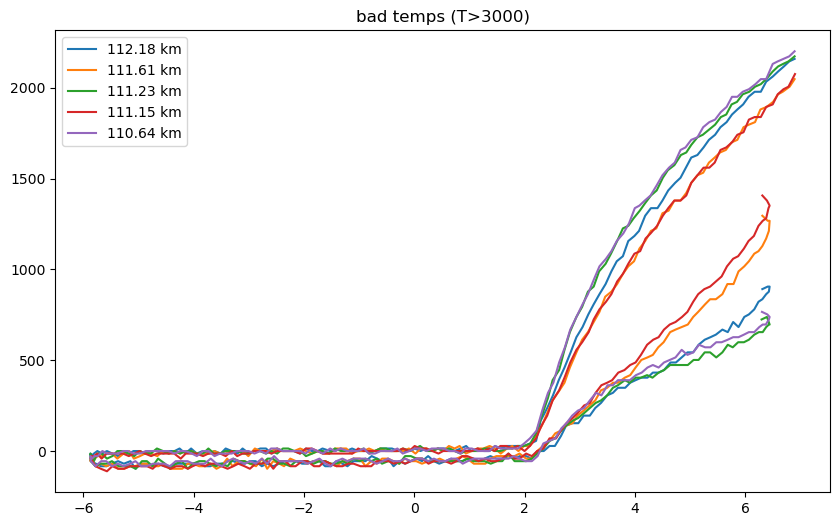

"\nfor n in indicesBad[11:20]:\n    VCheck = np.array(packets['packets']['Full'][f'{n}']['Voltage'][6:]) \n    ICheck = -np.array(packets['packets']['Full'][f'{n}']['Current0'][6:]) * 1e9\n    plt.plot(VCheck,ICheck)\nplt.show()"

In [14]:
indicesBad = np.where(Te[153:492] > 3000)[0]
indicesBad = indicesBad + 153
#print("Bad temp vals at indeces: ", indicesBad)
#print(len(indicesBad))
indicesGood = np.where((Te[153:492] < 1200) & (Te[153:492] > 400))[0]
indicesGood = indicesGood + 153
#print("Good temp vals at indeces: ", indicesGood)
"""
for n in indicesGood[25:30]:
    VCheck = np.array(packets['packets']['Full'][f'{n}']['Voltage'][6:]) 
    ICheck = -np.array(packets['packets']['Full'][f'{n}']['Current0'][6:]) * 1e9
    plt.plot(VCheck,ICheck)
    plt.title("Good temps (400 < T < 1200)")
plt.show()
"""
time = []
interpolated_alts = []
plt.figure(figsize=(10,6))
for n in indicesBad[30:35]:
    #print(n)
    start = packets['packets']['Full'][f'{n}']['Start']
    stop  = packets['packets']['Full'][f'{n}']['Stop']
    time = np.append(time, (start + stop)/2/1000 - 57)

    #finding corresponding altitudes
    altitudes_function = interp1d(times5, altitudes5)
    interpolated_alts = (altitudes_function(time))
    #print(interpolated_alts[-1])
    VCheck = np.array(packets['packets']['Full'][f'{n}']['Voltage'][6:]) 
    ICheck = -np.array(packets['packets']['Full'][f'{n}']['Current0'][6:]) * 1e9
    
    middle = len(VCheck) // 2

    plt.plot(VCheck,ICheck, label=f"{interpolated_alts[-1]:.2f} km")

    # add fit
    Vfit, Ifit, popt, pcov = gen_fit(VCheck, ICheck)
    
   # plt.scatter(Vfit, Ifit, label=f"fit for: {altitudes[-1]:.2f} km",s=1)
    plt.title("bad temps (T>3000)") 

plt.legend()
plt.show()
#print(altitudes)
"""
for n in indicesBad[11:20]:
    VCheck = np.array(packets['packets']['Full'][f'{n}']['Voltage'][6:]) 
    ICheck = -np.array(packets['packets']['Full'][f'{n}']['Current0'][6:]) * 1e9
    plt.plot(VCheck,ICheck)
plt.show()"""

## temperatures calculated from top vs bottom branches

In [15]:
timebad = []
TempTop = []
TempBot = []
plt.figure(figsize=(10,6))
for n in indicesBad:
    #print(n)
    start = packets['packets']['Full'][f'{n}']['Start']
    stop  = packets['packets']['Full'][f'{n}']['Stop']
    timebad = np.append(timebad, (start + stop)/2/1000 - 57)

    #finding corresponding altitudes
    altitudesCheck = np.interp(timebad, times5, altitudes5)
    #print(altitudes)
   # print(time)
    VCheck = np.array(packets['packets']['Full'][f'{n}']['Voltage'][6:]) 
    ICheck = -np.array(packets['packets']['Full'][f'{n}']['Current0'][6:]) * 1e9
    
    middle = len(VCheck) // 2

    # add fit
    VfitTopBranch, IfitTopBranch, poptTopBranch, pcovTopBranch = gen_fit(VCheck[middle:], ICheck[middle:])
    VfitBotBranch, IfitBotBranch, poptBotBranch, pcovBotBranch = gen_fit(VCheck[:middle], ICheck[:middle])
    TempTop = np.append(TempTop, poptTopBranch[6])
    TempBot = np.append(TempBot, poptBotBranch[6])
    
print(altitudesCheck)

C:\Users\ashto\AppData\Local\Temp\ipykernel_2676\3544887088.py:52: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1.0 + k*(x - V0))


[ 96.928535  97.33016   97.52292   97.71764   97.91108   98.1024
  98.29385   98.86833   99.054905  99.41451  111.48374  112.44864
 112.78904  113.086235 113.43189  113.66972  113.852025 114.04551
 114.057825 114.06615  114.063    114.023415 113.9288   113.803245
 113.5698   113.30642  113.26414  113.03718  112.98916  112.610235
 112.17721  111.6127   111.2304   111.150805 110.63847  110.10487
 109.62288  109.52399  108.353285 107.659625 107.05758  106.29127
 105.4796   105.193565 104.46358  104.313785 104.163    103.23415
 103.07876  102.450795 102.12844  101.4681   101.29954  101.125795
 100.06747   99.89134   99.171665  98.98914   98.61576   97.84784
  97.6586    97.46624   96.48627   96.2892    96.08868   95.2737
  95.0668    94.6491    94.01241   93.7997    93.58785   92.94247
  92.503     92.27356   92.04856   91.37116 ]


<Figure size 1000x600 with 0 Axes>

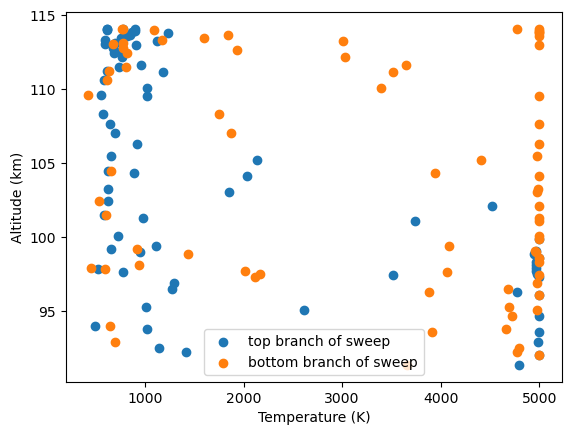

In [16]:
plt.scatter(TempTop, altitudesCheck, label='top branch of sweep')
plt.scatter(TempBot, altitudesCheck, label='bottom branch of sweep')
plt.xlabel("Temperature (K)")
plt.ylabel("Altitude (km)")
plt.legend()


10


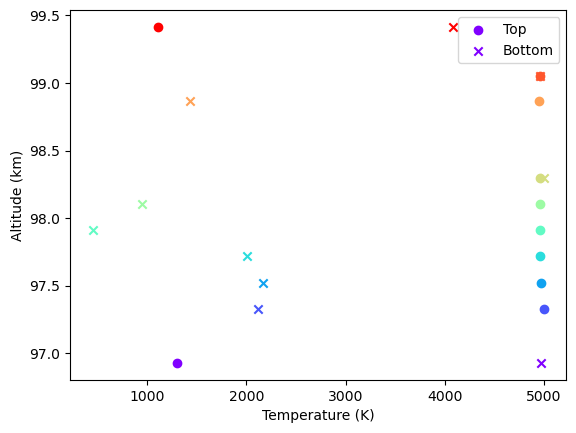

In [17]:
colors = plt.cm.rainbow(np.linspace(0, 1, len(TempTop)//7))
fig, ax = plt.subplots()
print(len(TempTop) // 7)
#first 10
for i in range(len(TempTop) // 7):
    ax.scatter(TempTop[i], altitudesCheck[i], color=colors[i], marker='o', label='Top' if i == 0 else "")
    ax.scatter(TempBot[i], altitudesCheck[i], color=colors[i], marker='x', label='Bottom' if i == 0 else "")
ax.set_xlabel('Temperature (K)')
ax.set_ylabel('Altitude (km)')
#ax.set_ylim(bottom=110, top=114.5)
ax.legend()


# Density vs Altitude

In [18]:
plt.scatter(ne[153:492],altitudes5_interp[153:492])
plt.ylabel("Altitude (km)")
plt.xlabel("Electron Density")

NameError: name 'altitudes5_interp' is not defined

# Temperature & density gradient ascending

Text(0.5, 0, 'Temperature')

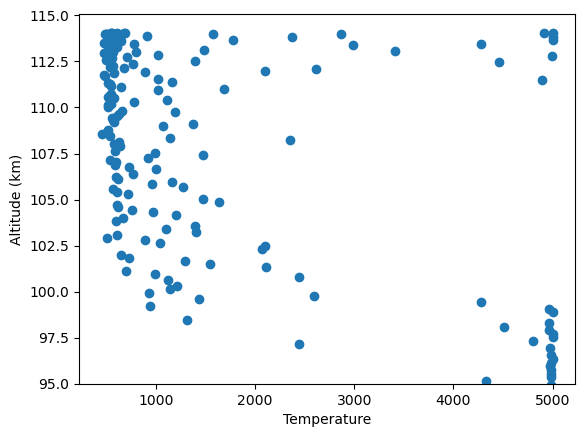

In [ ]:
new = np.where(altitudes5_interp == apogee5)[0][0] #cutting list at apogee to find temperatures going up
plt.scatter(Te[:new + 1], altitudes5_interp[:new + 1])
plt.ylim(95,apogee5 + 1)
plt.ylabel("Altitude (km)")
plt.xlabel("Temperature")

Text(0.5, 0, 'Electron Density')

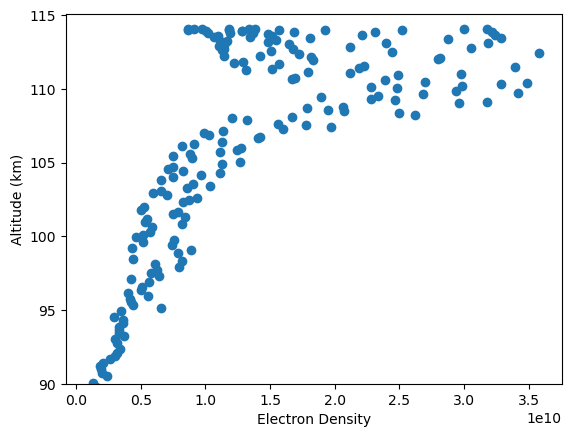

In [ ]:
plt.scatter(ne[:new + 1], altitudes5_interp[:new + 1])
plt.ylim(90, apogee5 + 1)
plt.ylabel("Altitude (km)")
plt.xlabel("Electron Density")

# Temperature & density gradient descending

Text(0.5, 0, 'Temperature')

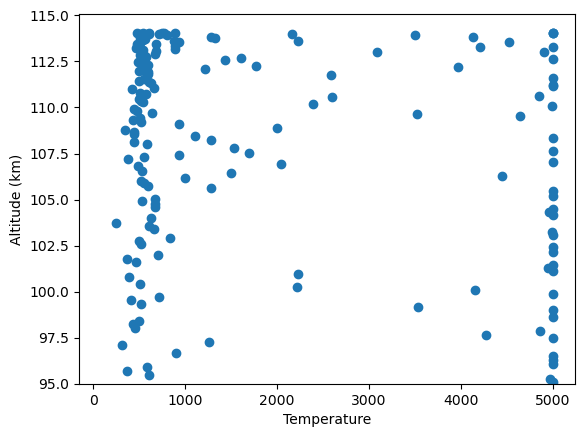

In [ ]:
new = np.where(altitudes5_interp == apogee5)[0][0] #cutting list at apogee to find temperatures going up
plt.scatter(Te[new:], altitudes5_interp[new:])
plt.ylim(95, apogee5+1)
plt.ylabel("Altitude (km)")
plt.xlabel("Temperature")
#plt.ylim(110.6,112.2)

Text(0.5, 0, 'Electron Density')

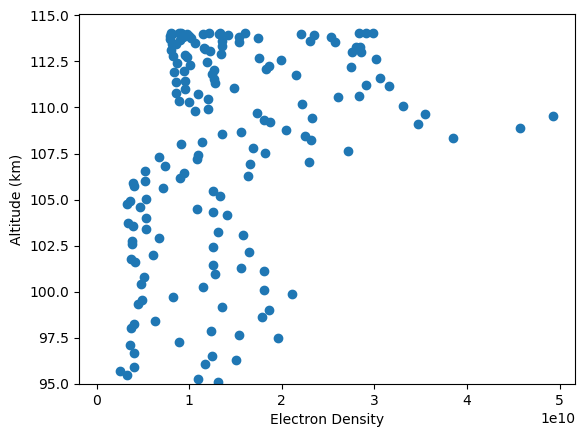

In [ ]:
plt.scatter(ne[new:], altitudes5_interp[new:])
plt.ylim(95,apogee5+1)
plt.ylabel("Altitude (km)")
plt.xlabel("Electron Density")


In [ ]:
testV = np.array(packets['packets']['Full']['552']['Voltage'][6:])
testI = np.array(packets['packets']['Full']['552']['Current0'][6:]) * -1e9
testI552 = np.array(packets['packets']['Full']['552']['Current0'][4:]) * -1e9
#a,b,c,d = R_fitting.gen_fit(testV, testI)
testI551 = np.array(packets['packets']['Full']['551']['Current0'][6:]) * -1e9
#print(testI)
#print(testI551)
print(testI552[:2])



[111.43695015  83.57771261]


# Full Sweeps

In [ ]:
#broken, rfitting not working for some reason

data = import_data(r'C:\Users\ashto\DAPPEr2\UDIP4\data\packets\UDIP_4_800s.json')

fullsweeps = data['packets']['Full']
totalkeys = sum(len(num) for num in fullsweeps.values() if isinstance(num, dict))
keynums = list(fullsweeps.keys())

densityVals = []
temperatureVals = []
timeVals = []

plt.figure(figsize=(12, 6)) 
for num in range(20,21):
    key = str(num)
    V = np.array(fullsweeps[key]['Voltage'])
    I = np.array(fullsweeps[key]['Current0' ]) * -1e9    #flip sign, get to nano amps
    #I[I == np.inf] = 1e-12
    #print(I[I == np.nan])

    x, y, popt, pcov = R_fitting.gen_fit(np.array(V), np.array(I))
    
    n = popt[3]
    T = popt[4]
    print(T)
    temperatureVals.append(T)
    densityVals.append(n)

    time = fullsweeps[key]['Start'] #in ms
    timeVals.append(time / 1000) #Get into s


    GroundType = fullsweeps[key]['GroundType']
    if(GroundType == 0):
        GroundType = "Grounded to probe"
    if(GroundType == 1):
        GroundType = "Grounded to rocket"
    

    # PLOTS FOR IV CURVES

    #print('electron density:', n, "Temperature:",T, 'time:', time, GroundType)
    #plt.figure()
    #plt.plot(V, I_swap, label=f'Sweep {num}')
    #plt.plot(x,y, label=f"Fit")
    #plt.xlabel('Voltage')
    #plt.ylabel('Current (nA)')
    #plt.title(f'Voltage vs Current for Sweep {num}\nt = {time / 1e3}s')
    #plt.legend()
    #plt.show()
    
    #spacecraft potential at like 2V

    # PLOTS FOR TEMPERATURE & OTHER THINGS


    #plt.plot(timeVals, temperatureVals)
    #plt.xlabel("Time (s)")
    #plt.ylabel("Temperature (K)")
    #now make temp vs altitude:

#print(timeVals)


1708.3662004794478


c:\Users\ashto\DAPPEr2\base\Fitting\RockSat_1_14_fitting_functions.py:47: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x + V0))


<Figure size 1200x600 with 0 Axes>

In [ ]:
iii = data['packets']['Full']['0']['Current0']
vvv = data['packets']['Full']['0']['Voltage']
print("Current:", iii)
print("Voltage:", vvv)
a, b, poptt, pcovv = R_fitting.gen_fit(np.array(vvv), np.array(iii))



Current: [-5.92008797653957e-07, -3.9699413489736203e-07, -2.994868035190592e-07, -1.8804985337243352e-07, -1.3233137829912068e-07, -9.054252199413072e-08, -7.661290322580427e-08, -6.268328445747784e-08, -6.268328445747784e-08, -6.268328445747784e-08, -6.268328445747784e-08, -6.268328445747784e-08, -6.964809384161441e-09, -4.875366568914785e-08, -2.089442815249498e-08, -3.4824046920817864e-08, -2.089442815249498e-08, -6.964809384161441e-09, 6.964809384164994e-09, 6.964809384164994e-09, -2.089442815249498e-08, -6.964809384161441e-09, -6.964809384161441e-09, -6.964809384161441e-09, -6.964809384161441e-09, -6.964809384161441e-09, 6.964809384164994e-09, 2.089442815249498e-08, 2.089442815249498e-08, 6.964809384164994e-09, 6.964809384164994e-09, -6.964809384161441e-09, 6.964809384164994e-09, 6.964809384164994e-09, -6.964809384161441e-09, 6.964809384164994e-09, 6.964809384164994e-09, 2.089442815249498e-08, 2.089442815249498e-08, 6.964809384164994e-09, 6.964809384164994e-09, 6.964809384164994e

ValueError: `ydata` must not be empty!

# Spin rate vs time

[0.01922563417890521, 0.009612817089452604, 0.07049399198931909]


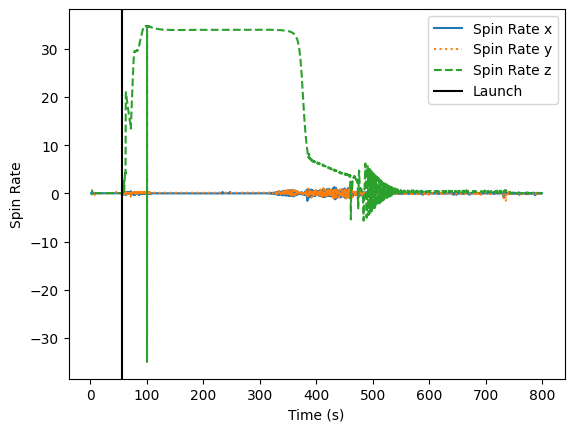

In [ ]:
data = import_data(r'C:\Users\ashto\DAPPEr2\UDIP4\data\packets\UDIP_4_800s.json')
eeee = data['packets']['Sensor']
total_keys = sum(len(num) for num in eeee.values() if isinstance(num, dict))
key_nums = list(eeee.keys())

spin_rates_x = []
spin_rates_y = []
spin_rates_z = []
time_vals = []
for key in key_nums:
    if 'Spin Rate' in eeee[key]:
        spin_rates_x.append(eeee[key]['Spin Rate'][0]) #not sure units
        spin_rates_y.append(eeee[key]['Spin Rate'][1])
        spin_rates_z.append(eeee[key]['Spin Rate'][2])
        time_vals.append(eeee[key]["Start"] / 1000) # divide by 1000 to get to seconds


print(eeee['100']['Spin Rate'])
plt.plot(time_vals, spin_rates_x, label="Spin Rate x")
plt.plot(time_vals, spin_rates_y, label="Spin Rate y",ls=':')
plt.plot(time_vals, spin_rates_z, label="Spin Rate z",ls='--')
plt.xlabel("Time (s)")
plt.ylabel("Spin Rate")
plt.axvline(57,color='k', label='Launch')
plt.legend()

# Dense sweeps

ValueError: array must not contain infs or NaNs

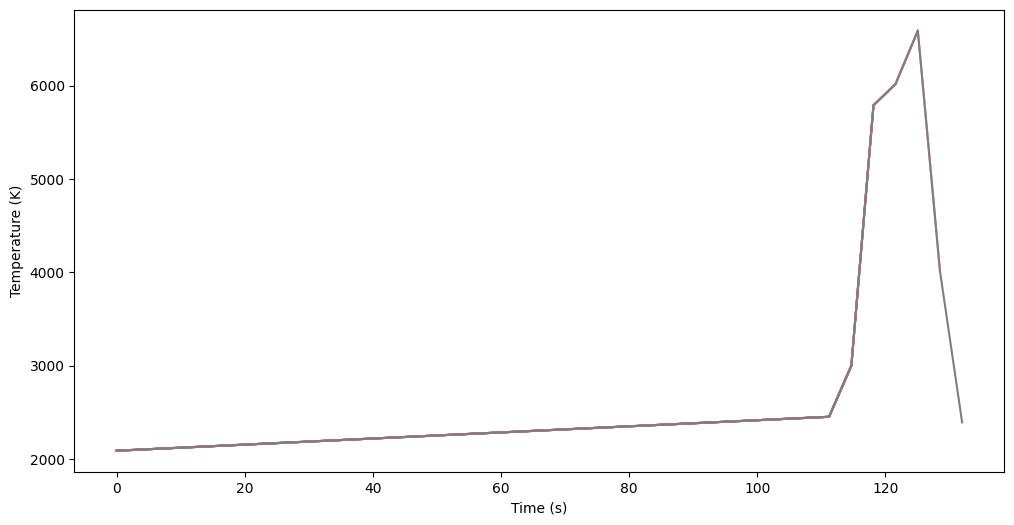

In [ ]:
densesweeps = data['packets']['Dense']
totalkeys = sum(len(num) for num in fullsweeps.values() if isinstance(num, dict))
keynums = list(densesweeps.keys())


densityVals = []
temperatureVals = []
timeVals = []


plt.figure(figsize=(12, 6)) 
for num in keynums:
    key = str(num)
    V = np.array(densesweeps[key]['Voltage'])
    I = np.array(densesweeps[key]['Current0' ]) * -1e9     #flip sign, get to nano amps

    x, y, popt, pcov = R_fitting.gen_fit(np.array(V), np.array(I))
    
    n = popt[3]
    T = popt[4]
    
    temperatureVals.append(T)
    densityVals.append(n)

    time = densesweeps[key]['Start'] #in ms
    timeVals.append(time / 1000) #Get into s

    GroundType = densesweeps[key]['GroundType']
    if(GroundType == 0):
        GroundType = "Grounded to probe"
    if(GroundType == 1):
        GroundType = "Grounded to rocket"
        
    #print('electron density:', n, "Temperature:",T, 'time:', time, GroundType)
    
    #plt.figure()
    #plt.plot(V, I_swap, label=f'Sweep {num}')
    #plt.plot(x,y, label=f"Fit")
    #plt.xlabel('Voltage')
    #plt.ylabel('Current (nA)')
    #plt.title(f'Voltage vs Current for Sweep {num}\nt = {time / 1e3}s')
    #plt.legend()
    #plt.show()

    
    plt.plot(timeVals, temperatureVals)
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (K)")


    


# Magnetometer

In [ ]:
sensor = data['packets']['Sensor']

magX = []
magY = []
magZ = []

magRawX = []
magRawY = []
magRawZ = []


time = []


for i in range (0, len(sensor)):
    magX.append(sensor[f'{i}']['Magnetic Field'][0])
    magRawX.append(sensor[f'{i}']['Magnetic Field'][0] * 95.43)
    
    magY.append(sensor[f'{i}']['Magnetic Field'][1])
    magRawY.append(sensor[f'{i}']['Magnetic Field'][1] * 95.43)
    
    magZ.append(sensor[f'{i}']['Magnetic Field'][2])
    magRawZ.append(sensor[f'{i}']['Magnetic Field'][2] * 95.43)
    
    time.append(sensor[f'{i}']['Start'] / 1000)
for i in range (0, len(time)):
    time[i] = time[i] - 60

magMagnitude = []
for i in range(0, len(magX)):
    magMagnitude.append(np.sqrt(magX[i]**2 + magY[i]**2 + magZ[i]**2))
print(magMagnitude)

[80.34037306731727, 79.33008838242792, 79.06732691478574, 79.7462621084917, 79.76276426201287, 79.80142408393363, 79.95377221962832, 79.51605376212136, 79.56688796302147, 79.61812526243071, 79.52327767005761, 79.49895060494427, 79.5411670325087, 79.73680511724388, 79.66186058605469, 79.88614839709578, 78.70655216088458, 78.97058825057233, 79.64437136670755, 79.67596789670758, 79.44553879161593, 78.59821651955407, 78.64680196574, 78.9371033580779, 79.86123112010692, 79.3753700923552, 78.99066315173238, 78.5340102955759, 79.58801630648622, 79.49592600286418, 78.95087840199805, 79.50750228732858, 79.11651100855637, 79.1873453179394, 79.17019083728607, 79.40201761345115, 80.21988326469588, 80.19509242529757, 79.42251409093018, 79.54747665888077, 80.08748717125602, 79.16962302276117, 79.60427987637158, 79.39574777719824, 79.60986753990836, 79.19484279975339, 78.93862647387711, 78.96163058295224, 79.9732201427367, 79.6530744578867, 79.18828288069923, 79.03795630320133, 79.7268515641889, 79.2

(-60.0, 740.0)

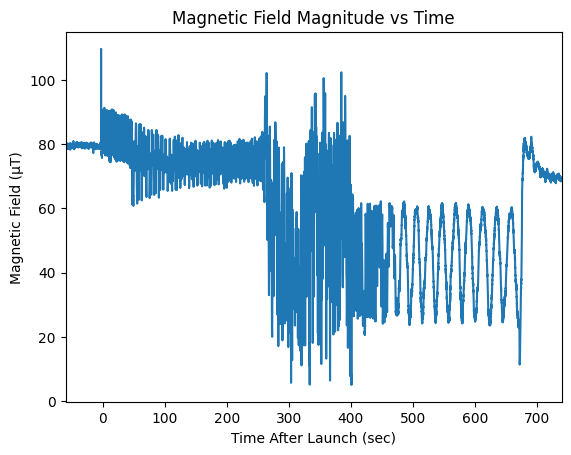

In [ ]:
plt.plot(time, magMagnitude)
plt.title("Magnetic Field Magnitude vs Time")
plt.ylabel("Magnetic Field (μT)")
plt.xlabel("Time After Launch (sec)")
plt.xlim(-60,740)
#UDIP lib

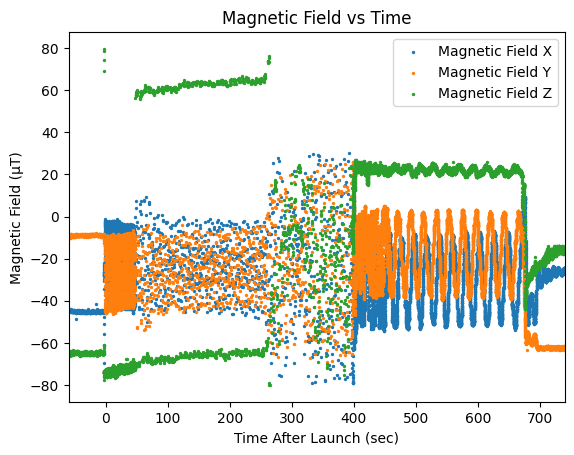

In [ ]:
plt.scatter(time, magX, label = 'Magnetic Field X', s=2)
plt.scatter(time, magY, label = 'Magnetic Field Y', s=2)
plt.scatter(time, magZ, label = 'Magnetic Field Z', s=2)
plt.title('Magnetic Field vs Time')
plt.ylabel('Magnetic Field (μT)')
plt.xlabel('Time After Launch (sec)')
plt.xlim(-60,740)
plt.legend()
plt.show()

dict_keys(['Start', 'Stop', 'Count', 'GroundType', 'Voltage', 'Current0', 'Current1', 'Current2', 'PhotoDiodeInitial', 'PhotoDiodeFinal'])